In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '340466',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/1N4DBN9ggYo7didRPyL2bg__thumb/img/diJqM9kyGQQPAybVCYd6B5UEv1A=/fit-in/200x150/filters:strip_icc()/pic6230642.jpg',
  'name': 'Unfathomable',
  'yearpublished': '2021'},
 {'id': '337324',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/sZxxoD_yC3UWr-cLn9mCCw__thumb/img/mUovP7_BK-0E9JjUYlaea9I9Hd8=/fit-in/200x150/filters:strip_icc()/pic6148517.jpg',
  'name': 'ADELE',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 27)
page number = 20 (max: 100, len: 18)
page number = 30 (max: 100, len: 14)
page number = 40 (max: 100, len: 11)
page number = 50 (max: 100, len: 5)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 74, len: 1)
comments_df shape: (104780, 4)


,id,username,rating,value
0,340466,Arcanum_Game_Studio,9,Wishlist
1,340466,atraangelis,N/A,Oh boy! day one buy.
2,340466,Barry Kendall,N/A,Intriguing. Look forward to learning more.
3,340466,Benwax123,9,Played as play tester
4,340466,bradray,N/A,21/09
...,...,...,...,...
104775,167791,z_zadar,9,Some games are so much fun. Others can be a li...
104776,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
104777,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
104778,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 16513 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          16347
10         16342
8          14437
7           7933
N/A         7212
           ...  
6.23           1
9.138          1
9.53333        1
3.92           1
7.93           1
Name: rating, Length: 544, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(81055, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7212, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Great Game, super components.'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'optimizing game, no topic available, only for optimizers...'

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
40/40 - 4s - loss: 0.5934 - accuracy: 0.7342 - val_loss: 0.5189 - val_accuracy: 0.8360
Epoch 2/100
40/40 - 2s - loss: 0.4757 - accuracy: 0.8450 - val_loss: 0.4337 - val_accuracy: 0.8515
Epoch 3/100
40/40 - 2s - loss: 0.3890 - accuracy: 0.8576 - val_loss: 0.3655 - val_accuracy: 0.8627
Epoch 4/100
40/40 - 2s - loss: 0.3243 - accuracy: 0.8788 - val_loss: 0.3314 - val_accuracy: 0.8717
Epoch 5/100
40/40 - 2s - loss: 0.2829 - accuracy: 0.8935 - val_loss: 0.3176 - val_accuracy: 0.8770
Epoch 6/100
40/40 - 2s - loss: 0.2524 - accuracy: 0.9056 - val_loss: 0.3137 - val_accuracy: 0.8774
Epoch 7/100
40/40 - 2s - loss: 0.2277 - accuracy: 0.9154 - val_loss: 0.3163 - val_accuracy: 0.8769
Epoch 8/100
40/40 - 2s - loss: 0.2067 - accuracy: 0.9240 - val_loss: 0.3239 - val_accuracy: 0.8734
Epoch 9/100
40/40 - 2s - loss: 0.1883 - accuracy: 0.9328 - val_loss: 0.3345 - val_accuracy: 0.8708
Epoch 10/100
40/40 - 2s - loss: 0.1730 - accuracy: 0.9392 - val_loss: 0.3473 - val_accuracy: 0.8685
27/27 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001FC87642640>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

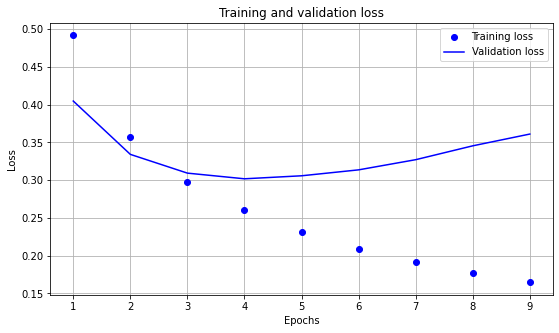

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

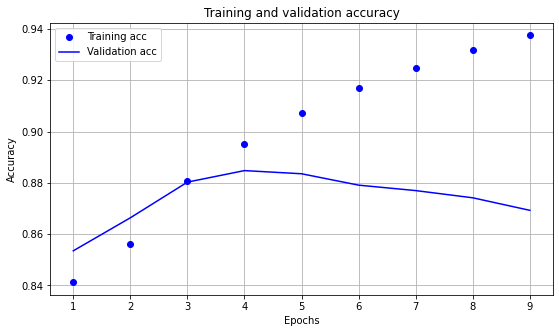

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Great Game, super components."
score: 1.000000
actual: 1

input:
"One of my favorite games. A worker placement game that focuses on the production of wine. The wine tokens have a nice touch. The theme is well implemented in the way the game works. A game that I will keep in my collection."
score: 1.000000
actual: 1

input:
"[b] HYBRID [/b] Subtype: Miniature's Game / Legacy / Campaign  - Cooperative Euro Role Playing Dungeon Crawler Game (1-4 Players) [Best:2] - Fantasy Adventures - Legacy - Complexity:3.77  *Expansions: Forgotten Circles  [b]Summary:[/b] One of the Best Campaign games out there!"
score: 1.000000
actual: 1

input:
"A very interesting bag building game. The medieval theme is well done. Tempted to play it like the designer's other (newer) game Altiplano where, like in a deck builder, you must go through all of your resources before 'reshuffling'."
score: 1.000000
actual: 1

input:
"Great game and scratches the old D&D itch pretty well."
score: 1.000000
actual: 1


C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Notes: Played (Tabletop Simulator)"
score: 1.000000

input:
"In FL  Cannot believe my redditgifts Santa got me this!  Thanks so much!"
score: 1.000000

input:
"Deck building: interested. Cute art and unique board: intrigued. Likelihood of playing with my group: high. Likelihood of playing with my family: low. So probably a pipe dream for now. :/"
score: 1.000000

input:
"Playing Time: 1.25-2.5 hours Best with 3-4 players (4 max)"
score: 1.000000

input:
"Here because it sounds like Gloomhaven-lite, but not sure about constant battles."
score: 0.000000

input:
"Contains every content release so far."
score: 1.000000

input:
"+ Ks Stretch Goals + City of steel + Lord of the sun + Terrain expansion"
score: 1.000000

input:
"Played a prototype version. Gameplay is very fluid and fast. Short turns with few rules to think about. The game is simple to get into and it engages all players very well, all the time. The circuit production, trade, buy is very well designed, especia

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001FF78819070>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.47


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.02


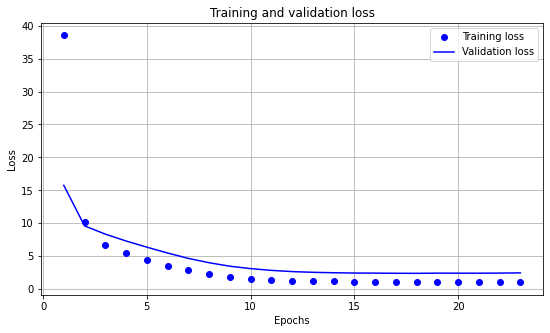

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

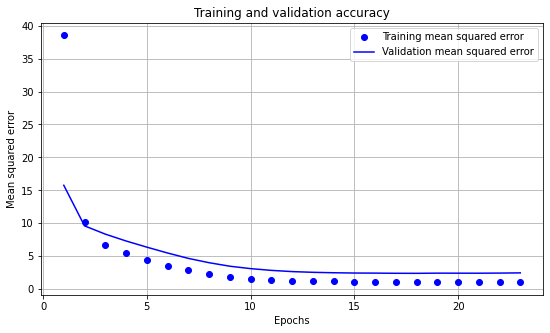

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Great Game, super components."
score: 8.66
actual: 8.00 

input: 
"One of my favorite games. A worker placement game that focuses on the production of wine. The wine tokens have a nice touch. The theme is well implemented in the way the game works. A game that I will keep in my collection."
score: 8.57
actual: 9.00 

input: 
"[b] HYBRID [/b] Subtype: Miniature's Game / Legacy / Campaign  - Cooperative Euro Role Playing Dungeon Crawler Game (1-4 Players) [Best:2] - Fantasy Adventures - Legacy - Complexity:3.77  *Expansions: Forgotten Circles  [b]Summary:[/b] One of the Best Campaign games out there!"
score: 8.45
actual: 8.60 

input: 
"A very interesting bag building game. The medieval theme is well done. Tempted to play it like the designer's other (newer) game Altiplano where, like in a deck builder, you must go through all of your resources before 'reshuffling'."
score: 7.97
actual: 8.00 

input: 
"Great game and scratches the old D&D itch pretty well."
score: 8.47
actual: 9

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Pre-ordered after playing the original. The original is great, rules aren't that complicated. You always have interesting choices to make.  It is a big and long game, so claim a whole evening for it."
    reg score: 8.24
    clf score: 1

"Sounds like a game that we would enjoy that can be won by different mechanisms. Theme a little thin, but ok. Build an engine and watch it run. Use bag to pull chits to use to get stuff. Many different ways to score points."
    reg score: 7.64
    clf score: 1

"SOLO GAME Recomendado entre los mejores juegos solitarios"
    reg score: 8.58
    clf score: 1

"I wish I could play this one with my friends more than I do."
    reg score: 8.81
    clf score: 1

"Haven't yet been able to find a group to play this with.  The show's popularity/awareness is waning I'm afraid."
    reg score: 6.47
    clf score: 1

"2200+950(upgrade token)+updated board250+upgrade vagabond (800)+insert 600"
    reg score: 7.02
    clf score: 0

"Waiting for Kickstarter - Dece

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.18 |           3870 |
| 162886 |          8.36 |           3568 |
| 164928 |          7.99 |           2687 |
| 167355 |          8.42 |           1865 |
| 167791 |          8.21 |           8330 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.03 |            253 |
| 162886 |          8.18 |            320 |
| 164928 |          8.15 |            247 |
| 167355 |          8.29 |            214 |
| 167791 |          8.35 |            443 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/1N4DBN9...","<a href=""https://boardgamegeek.com/boardgame/3...",9.000000,7.135943,7.644322,1,2021
1,"<img src=""https://cf.geekdo-images.com/sZxxoD_...","<a href=""https://boardgamegeek.com/boardgame/3...",9.000000,9.460675,9.276405,2,2021
2,"<img src=""https://cf.geekdo-images.com/By59lVy...","<a href=""https://boardgamegeek.com/boardgame/3...",9.500000,8.133779,8.437383,3,2021
3,"<img src=""https://cf.geekdo-images.com/MN0OvKe...","<a href=""https://boardgamegeek.com/boardgame/3...",7.603448,7.521173,7.589344,4,2021
4,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.796499,8.097459,7.821035,5,2020


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Unfathomable,9.000000,7.135943,7.644322,1,2021
2,,ADELE,9.000000,9.460675,9.276405,2,2021
3,,Now or Never,9.500000,8.133779,8.437383,3,2021
4,,Imperium: Classics,7.603448,7.521173,7.589344,4,2021
5,,Lost Ruins of Arnak,7.796499,8.097459,7.821035,5,2020


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Now or Never,9.500000,8.133779,8.437383,3,2021
2,,Deliverance,9.352381,8.612567,9.251037,12,2021
3,,Unfathomable,9.000000,7.135943,7.644322,1,2021
4,,ADELE,9.000000,9.460675,9.276405,2,2021
5,,Imperium: Legends,9.000000,7.669409,8.778235,50,2021


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,ADELE,9.000000,9.460675,9.276405,2,2021
2,,Deliverance,9.352381,8.612567,9.251037,12,2021
3,,Imperium: Legends,9.000000,7.669409,8.778235,50,2021
4,,Eclipse: Second Dawn for the Galaxy,8.721971,8.345028,8.664943,45,2020
5,,Middara: Unintentional Malum – Act 1,8.657721,8.602293,8.644930,41,2019


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Played once with the Eyre (my name means falcon, so that was pretty much obvious) together with my wife as Marquise against a stranger pair we met at a con. Pretty much helped her to win with domination. I am very interested in owning Root, but not sure about whom to play with. "
score: 5.96

"10.12.19 Dustin received this game as a birthday gift and I got to play it with him. I liked it, but I felt bad whenever the Dahan died. The relentless struggle of colonialist explorers vs. original people was heartbreaking. I would like to play again."
score: 6.08

"Base Game - Return to Night at the Zealots  Dunwich Legacy - Miskatonic Museum, Essex County Express, Blood on the Alter, Undimensioned and Unseen, Where Doom Awaits, Lost in Time and Space, Return to Dunwich Legacy  Path to Carcossa  Carnevale of Horrors Curse of Rougarou "
score: 6.22

"Heard great things and trying to get into the hobby through coop games. Ideally, they would scale with 2p  and +"
score: 6.78

"I am very interest

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test